In [55]:
import numpy as np
import pandas as pd
import os, sys, gc, warnings, time, datetime, random, pickle

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, TimeSeriesSplit, GroupKFold

from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [56]:
def display_importances(feature_importance_df_):
    all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Random Forest Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [57]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [58]:
TARGET = "k_class"
SEED = 42
seed_everything(SEED)

In [59]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [60]:
def kfold_randomforest(train_file_path, test_file_path, num_folds, stratified=False):
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    
    train_df = pd.read_pickle(train_file_path)
    test_df  = pd.read_pickle(test_file_path)
    
    train_df.columns = range(0, 38)
    test_df.columns = range(0, 38)
    df = pd.read_pickle("./structure_df_01.pkl")
    train_df["k_class"] = df["k_class"]

    feats = list(range(0, 38))
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
            
    scores = []
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=7,
        max_features='auto',
        min_samples_leaf=20, 
        n_jobs=-1, 
        verbose=1)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df[TARGET])):
        print(f"Fold: {n_fold}")
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[TARGET].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[TARGET].iloc[valid_idx]
        
        model.fit(train_x, train_y)
        
        del train_x, train_y
        gc.collect()
        
        oof_preds[valid_idx] = model.predict(valid_x)
        
        del valid_x, valid_y
        gc.collect()
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(model.feature_importances_)
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    display_importances(feature_importance_df)
    train_df.loc[:, "pred"] = model.predict(test_df[feats])

    return train_df

Fold: 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold: 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Fold: 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold: 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold: 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Run RandomForest with kfold - done in 5s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,k_class,pred
0,0.227064,-0.531081,-0.108556,1.021981,0.295825,0,0,0,0,1,...,0,0,1,0,0,0,0,0,9,2
4,-0.512119,2.232811,6.366625,-0.325103,-0.822874,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,7
5,-0.283409,-0.665905,-0.108556,1.021981,1.600973,0,0,0,1,0,...,0,0,0,0,0,1,0,0,8,0
14,1.876043,-0.194021,-0.108556,-0.325103,-0.263525,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,2
21,0.012101,2.772108,5.322241,-0.325103,-0.449974,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,-0.212565,0.277863,-0.108556,-0.325103,0.855174,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
818,-0.517225,-0.531081,-0.108556,1.021981,-0.636424,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,2
825,-0.478079,1.423867,-0.108556,3.716149,-0.822874,0,0,0,1,0,...,0,0,0,0,0,0,0,0,9,5
831,-0.517225,-0.531081,-0.108556,1.021981,-0.636424,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,2


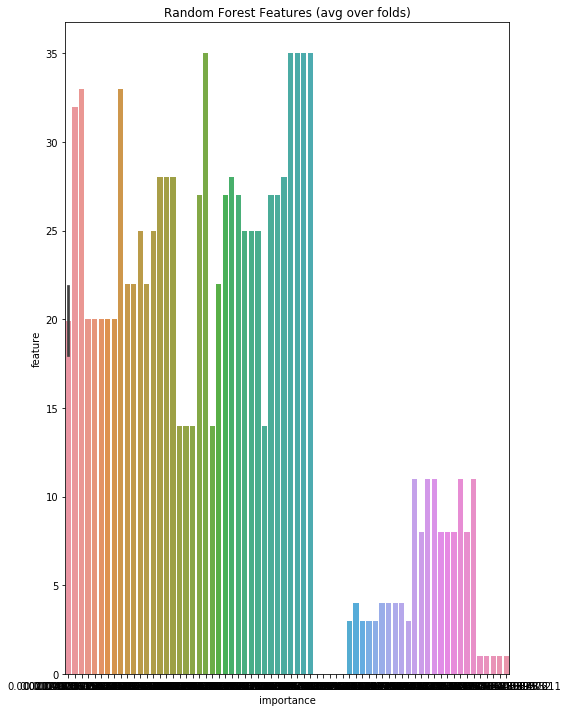

In [61]:
submission = None
with timer("Run RandomForest with kfold"):
    submission = kfold_randomforest(
        train_file_path="./structure_train_01.pkl", 
        test_file_path="./structure_train_01.pkl", 
        num_folds=5, stratified=False)

submission[submission["k_class"]!=submission["pred"]]